# Question 1


## Imports


In [1]:
%pip install scikeras

DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

cd "/content/drive/MyDrive/ML/HW3"

SyntaxError: invalid syntax (2756802035.py, line 4)

In [1]:
from tensorflow.keras import datasets, layers, models
from scikeras.wrappers import KerasClassifier
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from tensorflow.keras.optimizers import SGD,Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.datasets import cifar10
from tensorflow.image import rgb_to_grayscale
import numpy as np
from keras.callbacks import EarlyStopping

2023-11-14 09:26:47.637564: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-14 09:26:47.913000: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 09:26:49.439266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# load the training and testing data, scale it into the range [0, 1],
# then reshape the design matrix
print("[INFO] loading CIFAR-10 data...")
((trainX_full, trainY_full), (testX_full, testY_full)) = cifar10.load_data()
trainX_full = trainX_full.astype("float") / 255.0
testX = testX_full.astype("float") / 255.0
testY = testY_full

trainX, valX, trainY, valY = train_test_split(trainX_full, trainY_full, test_size=0.2, random_state=42)

# trainX = trainX.reshape((trainX.shape[0], 3072))
# testX = testX.reshape((testX.shape[0], 3072))

[INFO] loading CIFAR-10 data...


In [3]:
trainX_gray = rgb2gray(trainX)
testX_gray = rgb2gray(testX)
valX_gray = rgb2gray(valX)


## Part A


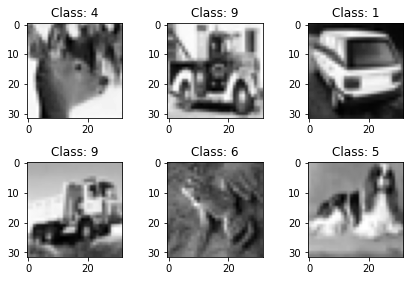

In [4]:
# Visualizing images from dataset
num_samples = 6
random_indices = np.random.choice(len(trainX), num_samples, replace=False)

for i, index in enumerate(random_indices):
    plt.subplot(2, 3, i + 1)
    plt.imshow(trainX_gray[index], cmap='gray')
    plt.title(f"Class: {trainY[index][0]}")

plt.tight_layout()
plt.show()

## Part B


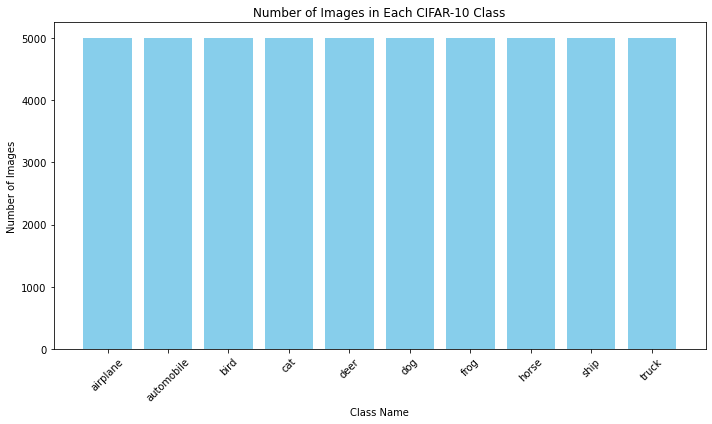

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Create a dictionary to count the number of images in each class
class_counts = {}
for i in range(10):
    class_counts[class_names[i]] = len(trainY_full[trainY_full == i])

# Extract class names and counts
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each CIFAR-10 Class')
plt.xticks(rotation=45)
plt.tight_layout()

## Part C


### part i

In [4]:
print(trainX.shape)
print(testX.shape)
print(valX.shape)

# Convert trainX to grayscale

trainX = trainX_gray.reshape((trainX_gray.shape[0], -1))

# Convert testX to grayscale
testX = testX_gray.reshape((testX_gray.shape[0], -1))

valX = valX_gray.reshape((valX_gray.shape[0],-1))

print(trainX.shape)
print(testX.shape)
print(valX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)
(10000, 32, 32, 3)
(40000, 1024)
(10000, 1024)
(10000, 1024)


In [5]:
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
valY = lb.transform(valY)
# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

In [8]:
# define the 3072-1024-512-10 architecture using Keras
def build_model(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

In [ ]:
model2 = KerasClassifier(build_fn=build_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25,nodes_per_layer=1024)

# Define hyperparameters for random search
param_dist = {
    'optimizer': [Adam(lr=0.001), SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3,0.2],
    # 'activation_function': ["relu"],
    'nodes_per_layer': [1024,512]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# time_callback_2 = TimeHistory()
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=3)
random_result = random_search.fit(trainX, trainY,validation_data=(valX, valY), callbacks=[early_stopping])

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### 3 models


In [13]:
# define the 3072-1024-512-10 architecture using Keras
def build_model_1(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=512):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

model = build_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])


Epoch 1/50
1250/1250 [==============================] - 8s 6ms/step - loss: 2.1241 - accuracy: 0.2093 - val_loss: 2.0026 - val_accuracy: 0.2776
Epoch 2/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.9874 - accuracy: 0.2837 - val_loss: 1.9498 - val_accuracy: 0.3022
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9298 - accuracy: 0.3056 - val_loss: 1.8906 - val_accuracy: 0.3185
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8912 - accuracy: 0.3180 - val_loss: 1.8787 - val_accuracy: 0.3304
Epoch 5/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.8616 - accuracy: 0.3302 - val_loss: 1.8453 - val_accuracy: 0.3351
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8307 - accuracy: 0.3410 - val_loss: 1.8109 - val_accuracy: 0.3511
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8117 - accuracy: 0.3501 - val_loss: 1.7968 - val_accuracy:

In [6]:
# define the 3072-1024-512-10 architecture using Keras
def build_model_2(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dropout(dropout_rate))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

model = build_model_2()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])

2023-11-14 09:04:50.490457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:04:50.709017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:04:50.709060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:04:50.714506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:04:50.714549: I tensorflow/compile

In [15]:
# define the 3072-1024-512-10 architecture using Keras
def build_model_3(optimizer='adam', dropout_rate=0.25,activation_function='relu',nodes_per_layer=1024):
  model = Sequential()
  model.add(Dense(nodes_per_layer, input_shape=(1024,), activation=activation_function))
  model.add(Dense(nodes_per_layer/2, activation=activation_function))
  model.add(Dense(nodes_per_layer/4, activation=activation_function))
  model.add(Dense(nodes_per_layer/8, activation=activation_function))
  model.add(Dense(10, activation="softmax"))

  model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])
  return model

model = build_model_3()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model.fit(trainX, trainY, validation_data=(valX, valY),epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
1250/1250 [==============================] - 8s 5ms/step - loss: 2.0617 - accuracy: 0.2421 - val_loss: 1.9759 - val_accuracy: 0.2793
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9161 - accuracy: 0.3104 - val_loss: 1.8996 - val_accuracy: 0.3189
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8524 - accuracy: 0.3353 - val_loss: 1.8123 - val_accuracy: 0.3564
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8031 - accuracy: 0.3510 - val_loss: 1.8221 - val_accuracy: 0.3495
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7642 - accuracy: 0.3685 - val_loss: 1.7868 - val_accuracy: 0.3603
Epoch 6/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7324 - accuracy: 0.3762 - val_loss: 1.7755 - val_accuracy: 0.3713
Epoch 7/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.7038 - accuracy: 0.3895 - val_loss: 1.7394 - val_accuracy:

### part ii

In [16]:
model = build_model_2()

In [7]:
model_final = build_model_2()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
H = model_final.fit(trainX, trainY, validation_data=(testX, testY),epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50


2023-11-14 09:05:00.062691: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 09:05:00.086183: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f3f33dd5140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 09:05:00.086236: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-14 09:05:00.342749: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-14 09:05:00.582689: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 09:05:00.632445: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 [==============================] - 10s 5ms/step - loss: 2.0829 - accuracy: 0.2340 - val_loss: 1.9503 - val_accuracy: 0.3011
Epoch 2/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9533 - accuracy: 0.2915 - val_loss: 1.8939 - val_accuracy: 0.3222
Epoch 3/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.9050 - accuracy: 0.3163 - val_loss: 1.8673 - val_accuracy: 0.3262
Epoch 4/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8493 - accuracy: 0.3316 - val_loss: 1.8110 - val_accuracy: 0.3540
Epoch 5/50
1250/1250 [==============================] - 6s 5ms/step - loss: 1.8132 - accuracy: 0.3467 - val_loss: 1.7939 - val_accuracy: 0.3584
Epoch 6/50
1250/1250 [==============================] - 7s 5ms/step - loss: 1.7882 - accuracy: 0.3568 - val_loss: 1.7743 - val_accuracy: 0.3607
Epoch 7/50
1250/1250 [==============================] - 7s 6ms/step - loss: 1.7572 - accuracy: 0.3675 - val_loss: 1.7445 - val_accuracy: 0.3714
Ep

In [10]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model_final.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

model_final.summary()

[INFO] evaluating network...
313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    airplane       0.52      0.28      0.36      1000
  automobile       0.47      0.50      0.49      1000
        bird       0.35      0.28      0.31      1000
         cat       0.30      0.17      0.22      1000
        deer       0.31      0.32      0.31      1000
         dog       0.49      0.27      0.35      1000
        frog       0.29      0.67      0.40      1000
       horse       0.56      0.42      0.48      1000
        ship       0.46      0.55      0.50      1000
       truck       0.44      0.53      0.48      1000

    accuracy                           0.40     10000
   macro avg       0.42      0.40      0.39     10000
weighted avg       0.42      0.40      0.39     10000

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dens

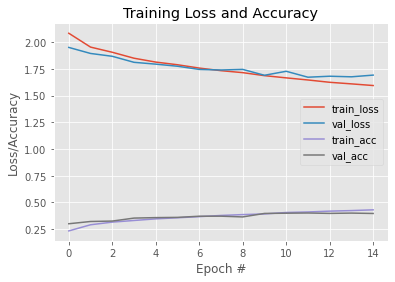

In [12]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

(10000,)
(10000,)


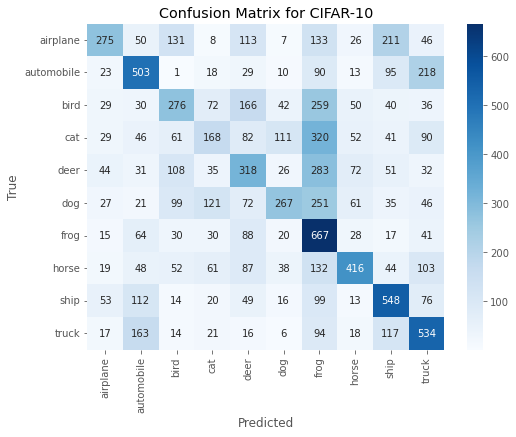

In [13]:
# Make predictions on the test set
y_pred = predictions
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(testY, axis=1)

print(y_pred_classes.shape)
print(y_true.shape)

# Calculate the confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred_classes)

# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CIFAR-10')
plt.show()

## Part D


### part i

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
# train_images = rgb2gray(train_images).reshape(50000,32,32,1)
# test_images = rgb2gray(test_images).reshape(10000,32,32,1)
# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels  = to_categorical(val_labels)


train_images = rgb_to_grayscale(train_images)
test_images = rgb_to_grayscale(test_images)
val_images = rgb_to_grayscale(val_images)

print(train_images.shape)
print(test_labels.shape)

2023-11-14 09:26:55.326792: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:26:55.564557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:26:55.564623: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:26:55.569155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 09:26:55.569235: I tensorflow/compile

(40000, 32, 32, 1)
(10000, 10)


#### randomserach

In [ ]:
def create_model(optimizer='adam', dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  history = model.fit(train_images, train_labels, epochs=20, batch_size=64, validation_data=(val_images, val_labels), verbose=1)
  return model

In [ ]:
model2 = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1,dropout_rate=0.25)

# Define hyperparameters for random search
param_dist = {
    'optimizer': ['adam', SGD(lr=0.001, momentum=0.9)],
    'dropout_rate': [0.3, 0.5,0.2]
}
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# Create RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model2, param_distributions=param_dist, n_iter=2, cv=2)
random_result = random_search.fit(train_images, train_labels,validation_data=(val_images, val_labels), callbacks=[early_stopping])

# Print the best parameters and corresponding accuracy
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))
means = random_result.cv_results_['mean_test_score']
stds = random_result.cv_results_['std_test_score']
params = random_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#### 3 models

In [5]:
def create_model_1(optimizer='adam', dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model_1()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/50


2023-11-14 09:18:23.263323: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-11-14 09:18:23.678748: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-14 09:18:25.731006: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 09:18:26.202366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 09:18:26.238207: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7faa228421e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 09:18:26.238249: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor devi

625/625 [==============================] - 16s 11ms/step - loss: 1.9338 - accuracy: 0.2849 - val_loss: 1.5472 - val_accuracy: 0.4398
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.4513 - accuracy: 0.4799 - val_loss: 1.1905 - val_accuracy: 0.5739
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 1.1910 - accuracy: 0.5833 - val_loss: 1.0152 - val_accuracy: 0.6411
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 1.0468 - accuracy: 0.6367 - val_loss: 0.9060 - val_accuracy: 0.6822
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.9440 - accuracy: 0.6719 - val_loss: 0.8492 - val_accuracy: 0.7048
Epoch 6/50
625/625 [==============================] - 6s 9ms/step - loss: 0.8693 - accuracy: 0.6979 - val_loss: 0.7625 - val_accuracy: 0.7367
Epoch 7/50
625/625 [==============================] - 6s 9ms/step - loss: 0.7989 - accuracy: 0.7222 - val_loss: 0.7490 - val_accuracy: 0.7440
Epoch 8/50
62

In [3]:
def create_model_2(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.25):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  # model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

# model = create_model_2()
# early_stopping = EarlyStopping(monitor='val_loss', patience=3)
# history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])

In [7]:
def create_model_3(optimizer=SGD(lr=0.001, momentum=0.9), dropout_rate=0.3):
  model = models.Sequential()
  model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(dropout_rate))
  model.add(Flatten())
  model.add(Dense(128, activation='elu', kernel_initializer='he_uniform'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(10, activation='softmax'))
  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

model = create_model_3()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/50


2023-11-14 09:22:21.212471: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


625/625 [==============================] - 9s 10ms/step - loss: 1.9811 - accuracy: 0.3002 - val_loss: 1.3844 - val_accuracy: 0.5038
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.3558 - accuracy: 0.5219 - val_loss: 1.1753 - val_accuracy: 0.5933
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 1.1804 - accuracy: 0.5904 - val_loss: 0.9301 - val_accuracy: 0.6785
Epoch 4/50
625/625 [==============================] - 6s 9ms/step - loss: 1.0711 - accuracy: 0.6307 - val_loss: 0.9400 - val_accuracy: 0.6744
Epoch 5/50
625/625 [==============================] - 6s 9ms/step - loss: 0.9974 - accuracy: 0.6567 - val_loss: 0.9653 - val_accuracy: 0.6824
Epoch 6/50
625/625 [==============================] - 6s 10ms/step - loss: 0.9572 - accuracy: 0.6738 - val_loss: 0.8464 - val_accuracy: 0.7129
Epoch 7/50
625/625 [==============================] - 6s 9ms/step - loss: 0.9047 - accuracy: 0.6915 - val_loss: 0.8232 - val_accuracy: 0.7231
Epoch 8/50
62

### part ii

In [4]:
model = create_model_2()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, validation_data=(val_images, val_labels), verbose=1, callbacks=[early_stopping])

Epoch 1/50


2023-11-14 09:27:04.052403: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-11-14 09:27:06.006857: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 09:27:06.385341: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-14 09:27:06.393571: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f02c512bd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 09:27:06.393618: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-14 09:27:06.652755: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-14 09:27:06.693737: I ./tensorflow/compiler/jit/de

625/625 [==============================] - 12s 11ms/step - loss: 1.8229 - accuracy: 0.3407 - val_loss: 1.5149 - val_accuracy: 0.4662
Epoch 2/50
625/625 [==============================] - 6s 10ms/step - loss: 1.3376 - accuracy: 0.5268 - val_loss: 1.2976 - val_accuracy: 0.5359
Epoch 3/50
625/625 [==============================] - 6s 10ms/step - loss: 1.0668 - accuracy: 0.6246 - val_loss: 1.0471 - val_accuracy: 0.6329
Epoch 4/50
625/625 [==============================] - 5s 9ms/step - loss: 0.8854 - accuracy: 0.6916 - val_loss: 0.9483 - val_accuracy: 0.6706
Epoch 5/50
625/625 [==============================] - 5s 8ms/step - loss: 0.7583 - accuracy: 0.7352 - val_loss: 0.9605 - val_accuracy: 0.6746
Epoch 6/50
625/625 [==============================] - 5s 8ms/step - loss: 0.6541 - accuracy: 0.7712 - val_loss: 0.9156 - val_accuracy: 0.6974
Epoch 7/50
625/625 [==============================] - 6s 9ms/step - loss: 0.5474 - accuracy: 0.8087 - val_loss: 1.0237 - val_accuracy: 0.6870
Epoch 8/50
62

313/313 - 2s - loss: 1.0852 - accuracy: 0.6958 - 2s/epoch - 6ms/step
0.6958000063896179


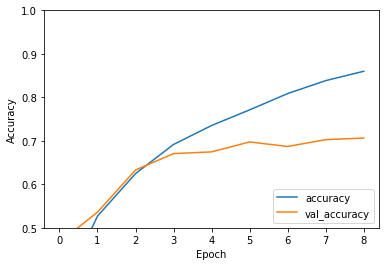

In [5]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

## Part E

## Part F

In [ ]:
from keras.applications import EfficientNetB0

# Load CIFAR-10 data
((X_train, y_train), (X_test, y_test)) = cifar10.load_data()

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Load pre-trained EfficientNetB0 model without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create a new model and add the pre-trained base model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune the model on CIFAR-10 data
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

# Question 2

## Imports

In [27]:
# import the necessary packages
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [28]:
df = pd.read_csv("datasets/Admission.csv")
print(df.columns)

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')


## Part A

In [29]:
mean_chance_of_admit = df["Chance of Admit "].mean()
print(mean_chance_of_admit)
df["Admission"] = (df["Chance of Admit "] > mean_chance_of_admit).astype(int)
print(df["Admission"])

0.72435
0      1
1      1
2      0
3      1
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Admission, Length: 400, dtype: int64


## Part B

In [30]:
svm_linear = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='linear'))
linear_svc =  make_pipeline(StandardScaler(), LinearSVC(random_state=0, tol=1e-5))
svm_rbf = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='rbf'))
svm_poly = make_pipeline(StandardScaler(), SVC(gamma='auto',kernel='poly'))

## Part C

In [31]:
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

for features in feature_combinations:
    X = df[features]
    y = df["Admission"]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train SVM models with the selected features
    svm_linear.fit(X_train, y_train)
    linear_svc.fit(X_train, y_train)
    svm_rbf.fit(X_train, y_train)
    svm_poly.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [ ]:
# Function to plot decision boundaries
def plot_decision_boundary(model, X, y, title):
    plt.figure(figsize=(8, 6))
    x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
    y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.title(title)
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

# List of SVM models
svm_models = [svm_linear, linear_svc, svm_rbf, svm_poly]

# List of feature combinations
feature_combinations = [
    ["CGPA", "SOP"],
    ["CGPA", "GRE Score"],
    ["SOP", "LOR "],
    ["LOR ", "GRE Score"]
]

# Visualize decision boundaries for each model and feature combination
for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]

        plt.figure(figsize=(8, 6))
        plot_decision_boundary(model, X, y, f"Model {i+1} with Features {features}")


## Part D

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465:

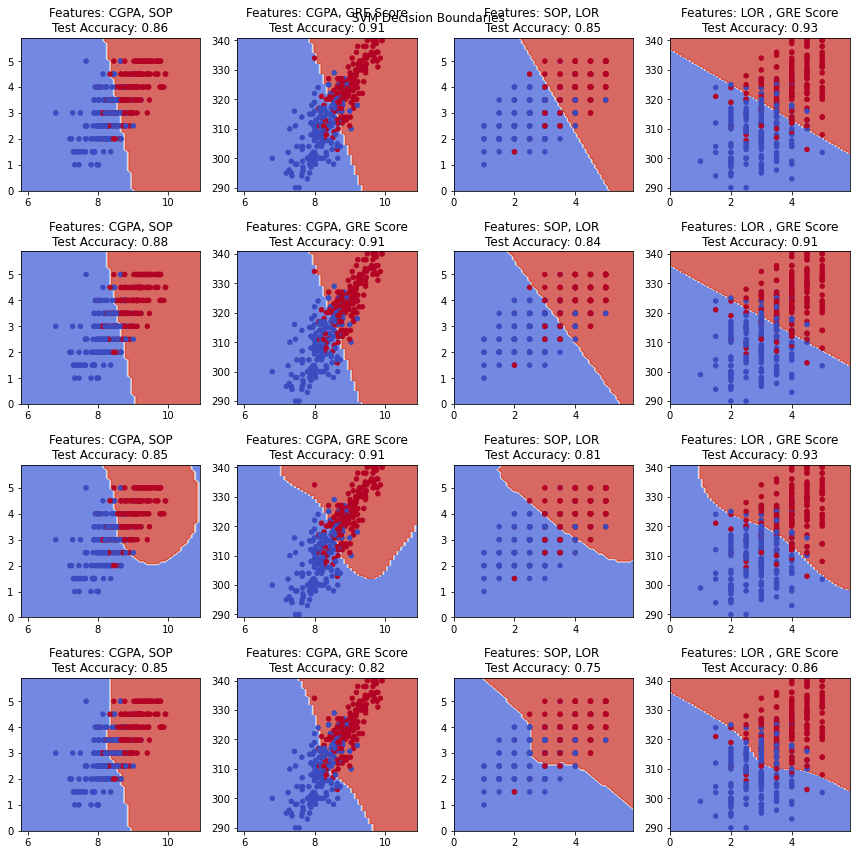

In [33]:
# Initialize subplots for visualization
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("SVM Decision Boundaries")

for i, model in enumerate(svm_models):
    for j, features in enumerate(feature_combinations):
        X = df[features]
        y = df["Admission"]
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train_subset = X_train
        X_test_subset = X_test

        # # Standardize the data for SVM
        # scaler = StandardScaler()
        # X_train_scaled = scaler.fit_transform(X_train_subset)
        # X_test_scaled = scaler.transform(X_test_subset)

        # Train the model
        model.fit(X_train, y_train)

        # Evaluate the model on the test set
        test_accuracy = model.score(X_test, y_test)

        # Visualize the decision boundary
        ax = axes[i, j]
        x_min, x_max = X_train.iloc[:, 0].min() - 1, X_train.iloc[:, 0].max() + 1
        y_min, y_max = X_train.iloc[:, 1].min() - 1, X_train.iloc[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
        ax.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, cmap=plt.cm.coolwarm, s=20)
        ax.set_title(f"Features: {', '.join(features)}\nTest Accuracy: {test_accuracy:.2f}")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


## Part E

## Part F